# Neutrality vs. Noise for Structured Reading

## Experimental Setting

We test the effect of neutrality and noise on IMDB data. 

1. Let $p$ be the probability of a noisy labels
1. Let $q$ be the probability of getting a neutral label
    

In [1]:
## Imports 
%matplotlib inline

STRUCTURED = '/Users/maru/MyCode/structured'
IMDB_DATA='/Users/maru/MyCode/data/imdb'
SRAA_DATA='/Users/maru/MyCode/data/sraa'
TWIITER_DATA = '/Users/maru/MyCode/data/twitter'

# STRUCTURED = '/Users/maru/My Code/structured'
# IMDB_DATA='/Users/maru/Dataset/aclImdb'
# SRAA_DATA='/Users/maru/Dataset/aviation/data'
# TWIITER_DATA = '/Users/maru/Dataset/twitter'

import sys
import os
sys.path.append(os.path.abspath(STRUCTURED))
sys.path.append(os.path.abspath('C:/cygwin/home/mramire8/python_code/structured/'))

import learner

from utilities.datautils import load_dataset
import experiment.base as exp


import utilities.experimentutils as exputil
import utilities.datautils as datautil
import numpy as np
import nltk
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('bmh')

In [2]:
## Get the data ready

vct = exputil.get_vectorizer({'vectorizer':'bow', 'limit':None, 'min_size':2})

imdb =  load_dataset("imdb",IMDB_DATA, keep_subject=True)

imdb.train.bow = vct.fit_transform(imdb.train.data)
imdb.test.bow = vct.transform(imdb.test.data)



In [3]:
# GET THE EXPERT
# IMDB NOISE SCALES
# 0.05 - scale= 0.142
# 0.1 - scale= 0.284
# 0.15 - scale= 0.425
# 0.2 - scale= 0.567
# 0.25 - scale= 0.709

noise_lvl = {0:0., 5:.142, 10:.284, 15:.425, 20:.567, 25:.709}

expert_config = {
    'type'           : "noisyreluctantscale", 
    'model'          : "lrl1",
    'parameter'      : 0.3,
    'costmodel'      : 1,
    'sent_tokenizer' : "first1snippet", #windowsnippet",
    'snip_size'      : (1,1),
    'threshold'      : .4,
    'scale': 0.
}
imdb_expert = exputil.get_expert(expert_config, size=len(imdb.train.data))
imdb_expert.fit(imdb.train.data, y=imdb.train.target, vct=vct)



In [7]:

# sent_tk = nltk.data.load('tokenizers/punkt/english.pickle')
sent_k = exputil.get_tokenizer(expert_config['sent_tokenizer'],snip_size=expert_config['snip_size'])

## Get Test data ready
rnd = np.random.RandomState(2345)
test_docs = rnd.permutation(len(imdb.test.target))




In [5]:
## Get learning curve data
from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

def get_learning_curve(estimator, X, y, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    return train_sizes, test_scores_mean, test_scores_std

def get_learning_curve2(estimator, data, new_target, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve. This uses 
    as fixed test set.
    """
    cv = cross_validation.ShuffleSplit(data.train.target.shape[0], n_iter=5, test_size=.0, random_state=12345)
    
    test_scores = []
    
    for train_index, _ in cv:
        trial_score = []
        for size in train_sizes:
            estimator.fit(data.train.bow[train_index[:size]], new_target[train_index[:size]])
            score = metrics.accuracy_score(data.test.target, estimator.predict(data.test.bow))
            trial_score.append(score)
        test_scores.append(trial_score)
    
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    return train_sizes, test_scores_mean, test_scores_std


## Plot noise graph based on cross validation
def plot_relabel(kvc, noise_p=.3):
    
    expert = NoisyExpert(None, noise_p)

    noisy_y = expert.label(None, y=data.train.target)
    
    plot_learning_curve(clf, "Accuracy of LRL2 with 30% Noise", data.train.bow, noisy_y, ylim=(0.4, 1.01), 
                        cv=kcv, n_jobs=4, train_sizes=sizes, label='Noise '+str(noise_p))


def get_relabel_curve(data, expert, clf, kcv, sizes, p, sents=None):
    
    rnd_gen = np.random.RandomState(12345)
    
    # get the predicted labels of the training data
#     new_target = expert.predict(data.train.bow)
    new_target = expert.predict(sents)

    
    # Flip a coin for every instance
    rnd_probs = rnd_gen.random_sample(data.train.target.shape[0])
    
#     new_target[rnd_probs < p] = data.train.target[rnd_probs < p]
    
    return get_learning_curve2(clf, data, new_target, train_sizes=sizes)



def relabel_curve(data, expert, clf, sent_tk=None, p_range=np.arange(.0, .5,.1), sents=None):
    kcv = cross_validation.KFold(len(data.train.target), n_folds=5, random_state=rnd,shuffle=True)
    sizes = range(50, 1500, 200)

    for p in p_range:
        x, y , st = get_relabel_curve(data, expert,clf, kcv, sizes, p, sents=sents)
        plt.errorbar(x, y, yerr=st, label='p= '+str(p))

    plt.legend(loc='best')
    plt.title("Relabel Test - LRL1")
    plt.show()




In [73]:
def label(query, expert, y=None):

    # Initizalize with all neutrals
    prediction = np.array([None] * len(query['snippets']), dtype=object)

    # Compute the uncertainty of the oracle
    proba = np.array([expert.oracle.predict_proba(q)[0] for q in query['bow']])
    unc = 1. - proba.max(axis=1)

    # Get remaining true labels
    prediction[unc < expert.reluctant_threhold] = y[unc < expert.reluctant_threhold]

    # Get the conditional error, for accuracy probability
    scaled_ce = unc * expert.get_scale_factor()

    # Get size in number of sentences
#     sents = expert.sent_detector.tokenize_sents(query['snippets'])
    size = [len(s[0].split()) for s in query['snippets']]
    # Flip a coin for every instance
    coin_flipped = [expert._flip_coin(x, s) for x, s in zip(query['index'], size)]

    for i, p in enumerate(prediction):
        if p is not None:  # If not neutral
            if coin_flipped[i] <= scaled_ce[i]:
                prediction[i] = 1 - prediction[i]

    return prediction

    

In [17]:

sents = np.array(sent_k.tokenize_sents(imdb.train.data))
sents_bow = np.array([vct.transform(s) for s in sents])


In [194]:
#Using the labels of all first-sentences in the data
p_vals = noise_lvl.keys() ## 0 to .25 noise
q_vals = np.arange(0., .55, .1) ## 0 to .5 neutrality
q_vals = np.arange(0.25, .5, .05) ## 0 to .5 neutrality

results = []
N = 3000
subsample = rnd.permutation(len(imdb.train.data))
cv = cross_validation.ShuffleSplit(n_samples, n_iter=3,test_size=0.3, random_state=0)
for p in p_vals:
    qres = []
    for q in q_vals: 
        print "*" * 20
        print "p=%s, q=%s" % (p,q)
        print "Noise: %s, Neutrality: %s" % (noise_lvl[p], q)
        imdb_expert.set_scale_factor(noise_lvl[p])
        imdb_expert.reluctant_threhold = q
        target = imdb.train.target[subsample[:N]]
        data_labels = label({'index':subsample[:N], 'bow':sents_bow[subsample[:N]], 'snippets':sents[subsample[:N]]}, imdb_expert, y=target)
        print np.unique(data_labels)
        neutrals = [l for l in data_labels if l == None]
        print "Oracle neutrality: %.4f" % (1. * len(neutrals) / N)
        print "Oracle accuracy: %.4f" % (1.* len(data_labels[data_labels == target])/(N-len(neutrals)))

        non_neutral = np.array([d != None for d in data_labels])
        
        # Student
        print "Test size: %d" % len(imdb.test.data)
        clf = exputil.get_classifier('lrl1', parameter=1)
        clf.fit(imdb.train.bow[subsample[:N]], target)
        acc0 = metrics.accuracy_score(imdb.test.target, clf.predict(imdb.test.bow)) 
        print "Accuracy True: %.4f" % acc0
        clf = exputil.get_classifier('lrl1', parameter=1)
        clf.fit(imdb.train.bow[subsample[:N]][non_neutral], [d for d,n in zip(data_labels, non_neutral) if n])
        acc = metrics.accuracy_score(imdb.test.target, clf.predict(imdb.test.bow))  

        print "Accuracy Noisy: %.4f" % acc.mean()
        print 
        qres.append([acc0, acc])
    results.append(qres)

********************
p=0, q=0.25
Noise: 0.0, Neutrality: 0.25
[None 0 1]
Oracle neutrality: 0.7483
Oracle accuracy: 1.0000
Test size: 24989
Accuracy True: 0.8363
Accuracy Noisy: 0.7757

********************
p=0, q=0.3
Noise: 0.0, Neutrality: 0.3
[None 0 1]
Oracle neutrality: 0.6540
Oracle accuracy: 1.0000
Test size: 24989
Accuracy True: 0.8359
Accuracy Noisy: 0.7921

********************
p=0, q=0.35
Noise: 0.0, Neutrality: 0.35
[None 0 1]
Oracle neutrality: 0.5167
Oracle accuracy: 1.0000
Test size: 24989
Accuracy True: 0.8361
Accuracy Noisy: 0.8018

********************
p=0, q=0.4
Noise: 0.0, Neutrality: 0.4
[None 0 1]
Oracle neutrality: 0.3627
Oracle accuracy: 1.0000
Test size: 24989
Accuracy True: 0.8360
Accuracy Noisy: 0.8166

********************
p=0, q=0.45
Noise: 0.0, Neutrality: 0.45
[None 0 1]
Oracle neutrality: 0.1793
Oracle accuracy: 1.0000
Test size: 24989
Accuracy True: 0.8361
Accuracy Noisy: 0.8316

********************
p=5, q=0.25
Noise: 0.142, Neutrality: 0.25
[None 0 1]

In [187]:
import copy
res_full = copy.copy(results)

In [131]:
print "\t",
print "\t".join("{:>4}".format(q) for q in q_vals)
for i,p in enumerate(p_vals):
    print "{}\t".format(p),
    print "\t".join("{:.4f}".format(r[1]) for r in results[i])

	0.25	 0.3	0.35	 0.4	0.45
0	0.7263	0.7579	0.7496	0.7597	0.7713
5	0.6929	0.7343	0.7339	0.7338	0.7502
10	0.6796	0.7206	0.7170	0.7209	0.7329
15	0.6806	0.6995	0.6897	0.7070	0.7095
20	0.6789	0.6868	0.6742	0.6853	0.6845
25	0.6538	0.6430	0.6548	0.6563	0.6451


In [134]:
print "\t",
print "\t".join("{:>4}".format(q) for q in q_vals)
for i,p in enumerate(p_vals):
    print "{}\t".format(p),
    print "\t".join("{:.4f}".format(r[1]) for r in results[i])

	0.25	 0.3	0.35	 0.4	0.45
0	0.8483	0.8625	0.8725	0.8789	0.8857
5	0.8260	0.8367	0.8445	0.8469	0.8507
10	0.8116	0.8115	0.8175	0.8207	0.8195
15	0.7970	0.7928	0.7968	0.7933	0.7899
20	0.7814	0.7764	0.7712	0.7663	0.7561
25	0.7608	0.7542	0.7481	0.7380	0.7306


In [ ]:
def relabel_curve(data, expert, clf, sent_tk=None, p_range=np.arange(.0, .5,.1), sents=None):

    kcv = cross_validation.KFold(len(data.train.target), n_folds=5, random_state=rnd,shuffle=True)
    sizes = range(50, 1500, 200)

    for p in p_range:

    get_learning_curve2(clf, data, new_target, train_sizes=sizes)

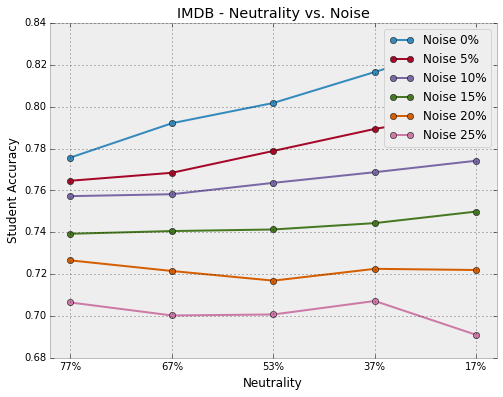

In [201]:
def plot_noise_by_neu(results, p_vals, q_vals, title=''):
    plt.figure(figsize=(8,6))
    for i,p in enumerate(p_vals[::1]):
        plt.plot(q_vals, [r[1] for r in results[i]], label="Noise {}%".format(p), marker="o")
    plt.legend()
    plt.xlabel("Neutrality")
    plt.xticks(q_vals, ["{}%".format(n) for n in [77,67,53,37,17]])
    plt.xlim([0.24,.46])
    plt.ylabel("Student Accuracy")
    plt.title("IMDB - Neutrality vs. Noise")
    plt.savefig("../graphs/" + "-".join(["noise_by_neu",title]) + ".pdf", bbox_inches="tight", dpi=200, transparent=True)


plot_noise_by_neu(results, p_vals, q_vals,title='N=3K')

In [165]:
print "\t",
print "\t".join("{:>4}".format(p) for p in p_vals)

for i,q in enumerate(q_vals):
    print "{}\t".format(q),
    print "\t".join("{:.4f}".format(r[i][1]) for r in results)

    

	   0	   5	  10	  15	  20	  25
0.25	0.8483	0.8260	0.8116	0.7970	0.7814	0.7608
0.3	0.8625	0.8367	0.8115	0.7928	0.7764	0.7542
0.35	0.8725	0.8445	0.8175	0.7968	0.7712	0.7481
0.4	0.8789	0.8469	0.8207	0.7933	0.7663	0.7380
0.45	0.8857	0.8507	0.8195	0.7899	0.7561	0.7306


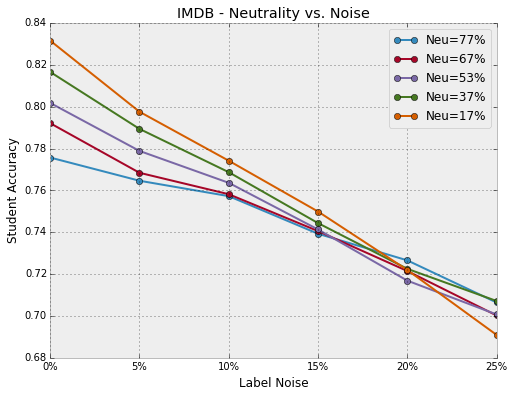

In [202]:
def plot_neu_by_noise(results, p_vals, q_vals, title=''):
    neus = [77,67,53,37,17]
    plt.figure(figsize=(8,6))
    for i,q in enumerate(q_vals):
        plt.plot(p_vals, [r[i][1] for r in results], label="Neu={}%".format(neus[i]), marker="o")
    plt.legend()
    plt.xlabel("Label Noise")
    plt.xticks(p_vals, ["{}%".format(n) for n in p_vals])
    plt.ylabel("Student Accuracy")
    plt.title("IMDB - Neutrality vs. Noise") 
    plt.savefig("../graphs/" + "-".join(["neu_by_noise",title]) + ".pdf", bbox_inches="tight", dpi=200, transparent=True)

plot_neu_by_noise(results, p_vals, q_vals,title='N=3K')

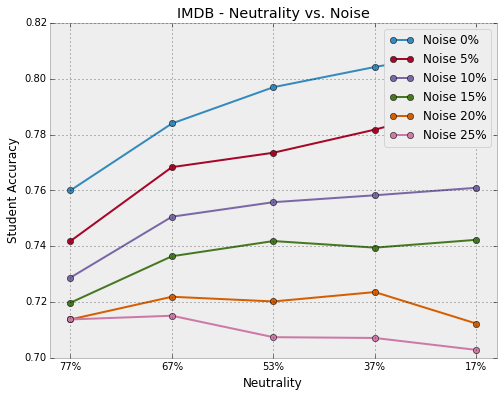

In [203]:
# N=2000
# res_2k = copy.copy(results)
plot_noise_by_neu(res_2k, p_vals, q_vals,title='N=2K')

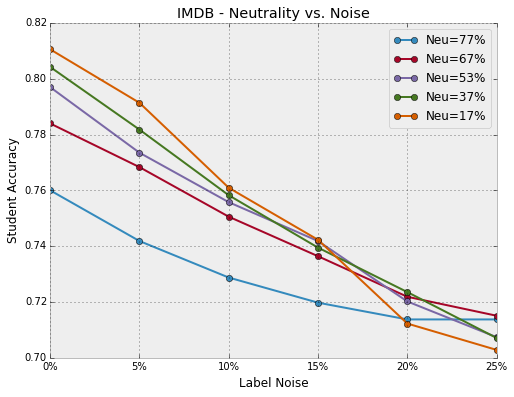

In [204]:
# N=2000
plot_neu_by_noise(res_2k, p_vals, q_vals,title='N=2K')

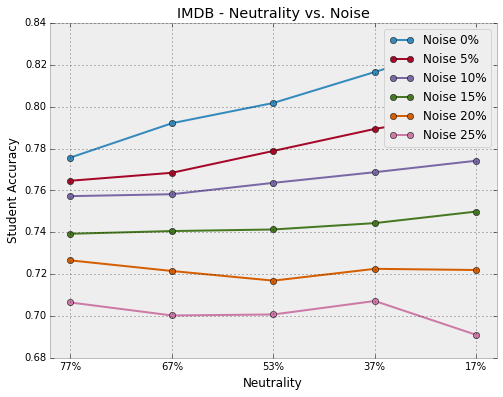

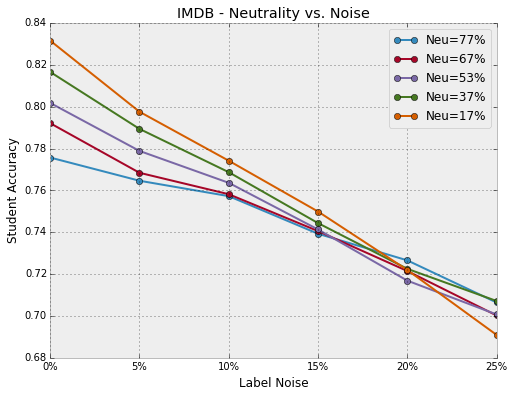

In [205]:
# N=3000
res_3k = copy.copy(results)
plot_noise_by_neu(res_3k, p_vals, q_vals,title='N=25K')
# N=3000
plot_neu_by_noise(res_3k, p_vals, q_vals,title='N=25K')

# Alternative Experiment with Noise and Neutrality

##Setup

We select a random size subsample of the data. We run the experiments t times to obtain an avarage. With a fixed number of correct labels for every run, we control number of noisy $p\times s$ and neutral labels $(10-p) \times s$. A run will see the same true labels, but varies the noisy-neutral set. 




In [351]:
def step_label(indices, target, n, p, s):
    true_lbl = target[indices[:n]] # true labels
    noise = []
    if s > 0:
        noise = indices[n:n+(p*s)]
    return np.append(true_lbl,1-target[noise]) #noisy labels

def trial_test(clf, data, n, p=100,rnd=None):
    N = total = n + p*10
    indices = rnd.permutation(len(data.train.data))
    trial = []
    test = []
    for s in range(0,11,2):
        total = n + p*s + p*(10-s)
        lbl = step_label(indices, data.train.target, n,p,s)
        clf.fit(data.train.bow[indices[:len(lbl)]], lbl)
        acc = metrics.accuracy_score(data.test.target, clf.predict(data.test.bow))
        trial.append(acc)
        print "N=%s, size=%s, noisy=%s, neutral=%s, acc=%.4f" % (N, len(lbl), p*s , p*(10-s), acc)
        test.append(len(lbl))
    return trial,test

def run_test(clf, data, n, p=100, runs=10):
    res = []
    sizes = []
    for run in range(runs):
        rnd2 =  np.random.RandomState(n+ 123 + (10*run))
        trial, size = trial_test(clf, data, n, p=p,rnd=rnd2)
        res.append(trial)
        sizes.append(size)
    return res, sizes

In [352]:
# Running experiment 
clf = exputil.get_classifier('lrl1', parameter=1)

trial1, sizes1 = run_test(clf, imdb, 1000, p=100, runs=5)


N=2000, size=1000, noisy=0, neutral=1000, acc=0.7872
N=2000, size=1200, noisy=200, neutral=800, acc=0.6961
N=2000, size=1400, noisy=400, neutral=600, acc=0.6201
N=2000, size=1600, noisy=600, neutral=400, acc=0.5516
N=2000, size=1800, noisy=800, neutral=200, acc=0.5178
N=2000, size=2000, noisy=1000, neutral=0, acc=0.4834
N=2000, size=1000, noisy=0, neutral=1000, acc=0.7911
N=2000, size=1200, noisy=200, neutral=800, acc=0.7027
N=2000, size=1400, noisy=400, neutral=600, acc=0.6378
N=2000, size=1600, noisy=600, neutral=400, acc=0.5810
N=2000, size=1800, noisy=800, neutral=200, acc=0.5355
N=2000, size=2000, noisy=1000, neutral=0, acc=0.4974
N=2000, size=1000, noisy=0, neutral=1000, acc=0.7756
N=2000, size=1200, noisy=200, neutral=800, acc=0.6914
N=2000, size=1400, noisy=400, neutral=600, acc=0.6141
N=2000, size=1600, noisy=600, neutral=400, acc=0.5689
N=2000, size=1800, noisy=800, neutral=200, acc=0.5305
N=2000, size=2000, noisy=1000, neutral=0, acc=0.4927
N=2000, size=1000, noisy=0, neutra

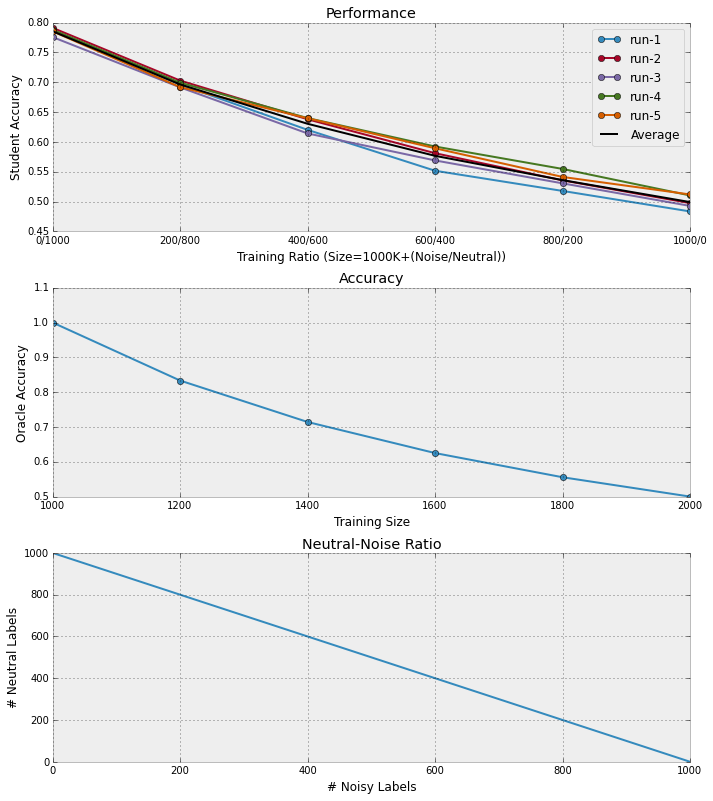

In [357]:
def plot_runs(sizes, trial, p, plotall=True):
    title = max(sizes[0])
    plt.figure(figsize=(10,11.2))
    plt.subplot(311)
    i =1
    if plotall:
        for x,y in zip(sizes, trial):
            plt.plot(x,y,'o-',label="run-{}".format(i))
            i +=1
    plt.plot(np.mean(sizes,axis=0),np.mean(trial,axis=0),'k-',label="Average")
    plt.xticks(sizes[0], ["{}/{}".format(p*s*2, p*(10-s*2)) for s in range(0,len(sizes[0])+1,1)])
    plt.title("Performance")
    plt.xlabel("Training Ratio (Size=%sK+(Noise/Neutral))"% min(sizes[0]))
    plt.ylabel("Student Accuracy")
    plt.legend(loc='best')#, bbox_to_anchor=(1, 0.5))
    plt.subplot(313)

    plt.plot([s-1000 for s in sizes[0][::-1]],[s-1000 for s in sizes[0]])
    plt.title("Neutral-Noise Ratio")
    plt.xlabel('# Noisy Labels')
    plt.ylabel('# Neutral Labels')
    plt.xticks([s-1000 for s in sizes[0]])
    plt.subplot(312)

    plt.plot(sizes[0], [min(sizes[0])/s for s in np.mean(sizes,axis=0)],'o-')
    plt.title('Accuracy')
    plt.ylabel('Oracle Accuracy')
    plt.xlabel('Training Size')
#     plt.ylim([.48,1.02])
    plt.tight_layout()
    plt.savefig("../graphs/" + "-".join(["neu_by_noise_v2","train_{}".format(title)]) + ".pdf", bbox_inches="tight", dpi=200, transparent=True)

plot_runs(sizes1, trial1,100,plotall=True)

In [322]:
p=100
sizes[0], ["{}/{}".format(p*s*2, p*(10-s*2)) for s in range(0,len(sizes[0]),1)]

# N=2000, size=1000, noisy=0, neutral=1000, acc=0.7825
# N=2000, size=1200, noisy=200, neutral=800, acc=0.6955
# N=2000, size=1400, noisy=400, neutral=600, acc=0.6371
# N=2000, size=1600, noisy=600, neutral=400, acc=0.5822
# N=2000, size=1800, noisy=800, neutral=200, acc=0.5451
# N=2000, size=2000, noisy=1000, neutral=0, acc=0.4957

([1000, 1200, 1400, 1600, 1800, 2000],
 ['0/1000', '200/800', '400/600', '600/400', '800/200', '1000/0'])

In [354]:
# Running experiment 
clf = exputil.get_classifier('lrl1', parameter=1)

trial5, sizes5 = run_test(clf, imdb, 5000, p=500, runs=5)



N=10000, size=5000, noisy=0, neutral=5000, acc=0.8489
N=10000, size=6000, noisy=1000, neutral=4000, acc=0.7441
N=10000, size=7000, noisy=2000, neutral=3000, acc=0.6674
N=10000, size=8000, noisy=3000, neutral=2000, acc=0.6097
N=10000, size=9000, noisy=4000, neutral=1000, acc=0.5545
N=10000, size=10000, noisy=5000, neutral=0, acc=0.5130
N=10000, size=5000, noisy=0, neutral=5000, acc=0.8489
N=10000, size=6000, noisy=1000, neutral=4000, acc=0.7354
N=10000, size=7000, noisy=2000, neutral=3000, acc=0.6568
N=10000, size=8000, noisy=3000, neutral=2000, acc=0.5839
N=10000, size=9000, noisy=4000, neutral=1000, acc=0.5404
N=10000, size=10000, noisy=5000, neutral=0, acc=0.4998
N=10000, size=5000, noisy=0, neutral=5000, acc=0.8509
N=10000, size=6000, noisy=1000, neutral=4000, acc=0.7484
N=10000, size=7000, noisy=2000, neutral=3000, acc=0.6658
N=10000, size=8000, noisy=3000, neutral=2000, acc=0.6017
N=10000, size=9000, noisy=4000, neutral=1000, acc=0.5504
N=10000, size=10000, noisy=5000, neutral=0, 

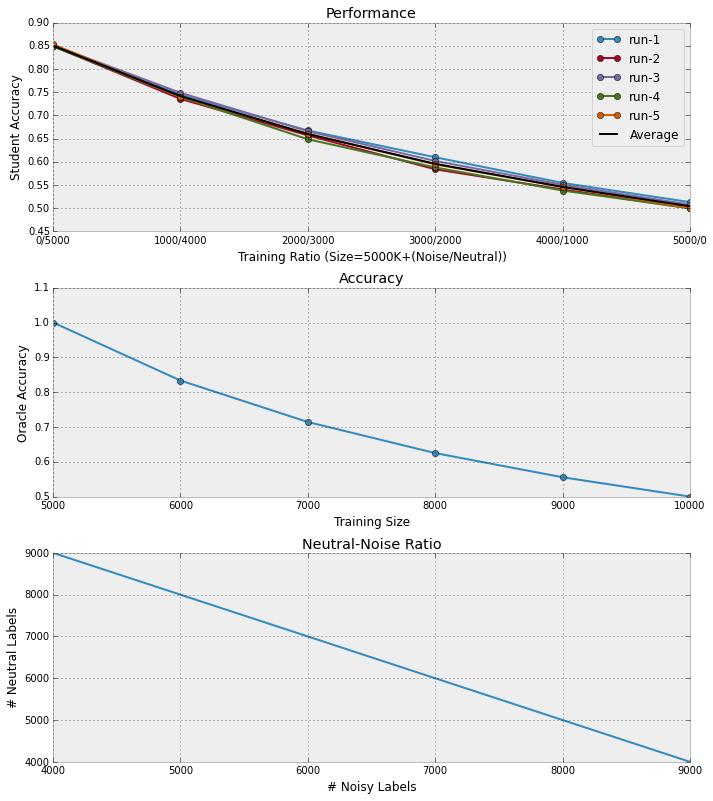

In [356]:
plot_runs(sizes5, trial5,500,plotall=True)

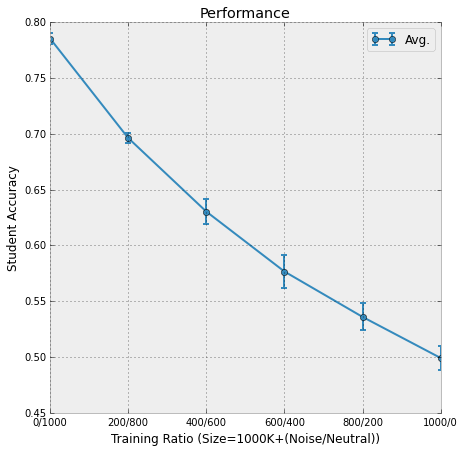

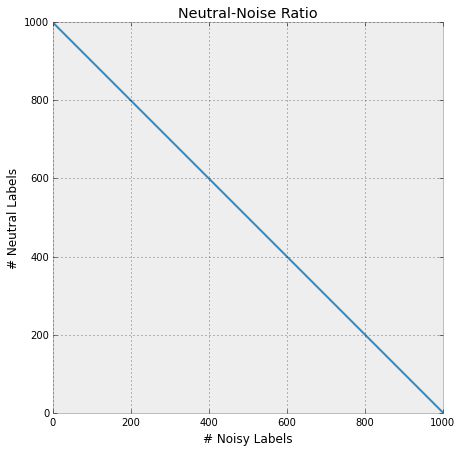

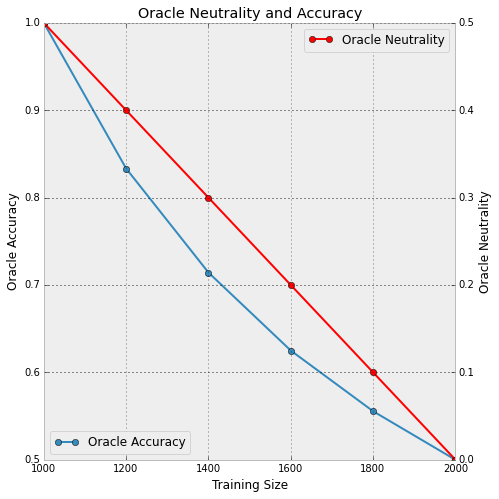

In [384]:
def plot_runs_v2(sizes, trial, p, plotall=True):
    title = max(sizes[0])
    plt.figure(figsize=(7,7))

    i =1
    if plotall:
        for x,y in zip(sizes, trial):
            plt.plot(x,y,'o-',label="run-{}".format(i))
            i +=1
        plt.plot(np.mean(sizes,axis=0),np.mean(trial,axis=0),'k-',label="Average")
    else:
        plt.errorbar(np.mean(sizes,axis=0),np.mean(trial,axis=0), yerr=np.std(trial, axis=0),label='Avg.',fmt='o-',capthick=2)
    plt.xticks(sizes[0], ["{}/{}".format(p*s*2, p*(10-s*2)) for s in range(0,len(sizes[0])+1,1)])
    plt.title("Performance")
    plt.xlabel("Training Ratio (Size=%sK+(Noise/Neutral))"% min(sizes[0]))
    plt.ylabel("Student Accuracy")
    plt.legend(loc='best')#, bbox_to_anchor=(1, 0.5))
    plt.savefig("../graphs/" + "-".join(["neu_by_noise_v2","train_{}".format(title),"stu"]) + ".pdf", bbox_inches="tight", dpi=200, transparent=True)

    plt.figure(figsize=(7,7))
    plt.plot([s-1000 for s in sizes[0][::-1]],[s-1000 for s in sizes[0]])
    plt.title("Neutral-Noise Ratio")
    plt.xlabel('# Noisy Labels')
    plt.ylabel('# Neutral Labels')
    plt.xticks([s-1000 for s in sizes[0]])
    plt.savefig("../graphs/" + "-".join(["neu_by_noise_v2","train_{}".format(title),"ratio"]) + ".pdf", bbox_inches="tight", dpi=200, transparent=True)


#     plt.subplot(312)
    plt.figure(figsize=(7,7))
    ax = plt.gca()
#     ax2.plot(t, s2, 'r.')
    ax2 = ax.twinx()


    ax.plot(sizes[0], [min(sizes[0])/s for s in np.mean(sizes,axis=0)],'o-', label='Oracle Accuracy')
    ax.set_ylabel('Oracle Accuracy')
    ax.set_ylim([0.5,1.0])
    ax.set_xlabel('Training Size')
    ax2.plot(sizes[0], [(max(sizes[0])-s)/max(sizes[0]) for s in np.mean(sizes,axis=0)],'ro-', label='Oracle Neutrality')
    ax.legend(loc='lower left')


    plt.title('Oracle Neutrality and Accuracy')
#     plt.ylabel('Oracle Accuracy')
    ax2.set_ylabel('Oracle Neutrality')
    ax2.legend(loc='upper right')
#     plt.ylim([.48,1.02])
    plt.tight_layout()
    plt.savefig("../graphs/" + "-".join(["neu_by_noise_v2","train_{}".format(title),"ora"]) + ".pdf", bbox_inches="tight", dpi=200, transparent=True)


plot_runs_v2(sizes1, trial1,100,plotall=False)

In [367]:
sizes1[0]

[1000, 1200, 1400, 1600, 1800, 2000]

In [386]:
imdb.train.keys()

['target', 'DESCR', 'bow', 'target_names', 'filenames', 'data']

In [435]:
sent_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
al = learner.strategy.StructuredLearner(None)

rnd = np.random.RandomState(1234)

N = 10000

sample = rnd.permutation(len(imdb.train.data))

clf_d = exputil.get_classifier('lrl1', parameter=1)
x_txt = imdb.train.data[sample[:N]]
x, y = imdb.train.bow[sample[:N]], imdb.train.target[sample[:N]]

clf_d.fit(x,y)

s, y_s  = al.convert_to_sentence(x_txt, y, sent_splitter)
s_bow = vct.transform(s)

pred = clf.predict(s_bow)
print metrics.accuracy_score(y_s, pred)


0.498417440452


In [436]:
from collections import Counter
probs = clf.predict_proba(s_bow)
print np.mean(1-probs.max(axis=1))

0.362306119156


In [437]:
d_s = np.array(sent_splitter.tokenize_sents(x_txt))

In [438]:
print np.sum(len(d) for d in d_s)
print pred[:30]
print y_s[:30]
print len(s)
print s_bow.shape
print metrics.accuracy_score(y, clf.predict(x))

123850
[0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
123850
(123850, 267154)
0.5008


In [439]:
print metrics.accuracy_score(imdb.test.target, clf.predict(imdb.test.bow))

0.500660290528


In [445]:
# classifier trained on all documents, tested on documents (test split)
clf2 = exputil.get_classifier('lrl1', parameter=1)
clf2.fit(imdb.train.bow, imdb.train.target)
print metrics.accuracy_score(imdb.test.target, clf2.predict(imdb.test.bow))


0.888470927208


In [444]:
print imdb.train.bow.shape

(24991, 267154)


In [453]:
sent_k.tokenize_sents(['uno. dos .tres'])

[['uno.']]